## GPP Contribution EDA
Goal: To determine, for each site, where the most GPP comes from, and where the most variance is as well

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import zscore, skew
from sklearn.cluster import KMeans
import warnings 
import os.path
import io
import sys
from tqdm import tqdm
from datetime import date
sys.path.append('../tools')
from CloudIO.AzStorageClient import AzStorageClient

today = str(date.today())
warnings.filterwarnings('ignore') 

# Set paths
wd = '/Users/jetcalz07/Desktop/MIDS/W210_Capstone/co2-flux-hourly-gpp-modeling/'
data = wd + 'data/datasets/'
hh_data = data + 'half_hourly/'
code = wd + 'code/src/'
eda_img = code + 'EDA/images/'

#### Initialize Azure Connection

In [2]:
# Mac or Windows
pc = "mac"
if pc == "windows":
    slash = "\\"
else:
    slash = "/"

# Define Constants
root_dir =  os.path.abspath(os.getcwd()+f"..{slash}..{slash}..{slash}..{slash}")
tmp_dir = root_dir + f"{slash}.tmp"
cred_dir = root_dir + f"{slash}.cred"
az_cred_file = cred_dir + f'{slash}azblobcred.json'

if not (os.path.exists(tmp_dir)):
    os.mkdir(tmp_dir)

# Initialize Azure Storage Client
azStorageClient = AzStorageClient(az_cred_file)

# List blobs names under the container "data_full_half_hourly"
container_name = 'full-half-hourly-raw'
blob_name_list = azStorageClient.listBlobs(container_name)
for i, blob in enumerate(blob_name_list):
    print(f'{i:3} {blob.name}')
    if i > 4:
        break

  0 data_full_half_hourly_raw_v0_1_AR-SLu.csv
  1 data_full_half_hourly_raw_v0_1_AR-Vir.csv
  2 data_full_half_hourly_raw_v0_1_AT-Neu.csv
  3 data_full_half_hourly_raw_v0_1_AU-ASM.csv
  4 data_full_half_hourly_raw_v0_1_AU-Ade.csv
  5 data_full_half_hourly_raw_v0_1_AU-Cpr.csv


#### Define Functions

In [3]:
def parse_timestamp(timestamp):
    date = timestamp[0:8]
    year = int(timestamp[0:4])
    month = int(timestamp[4:6])
    day = int(timestamp[6:8])
    hour = int(timestamp[8:10])
    mins = int(timestamp[10:12])

    return date, year, month, day, hour, mins

def get_season(df):
    df['SEASON'] = ''
    df.loc[df['MONTH'].isin([12, 1, 2]), 'SEASON'] = 'WINTER'
    df.loc[df['MONTH'].isin([3, 4, 5]), 'SEASON'] = 'SPRING'
    df.loc[df['MONTH'].isin([6, 7, 8]), 'SEASON'] = 'SUMMER'
    df.loc[df['MONTH'].isin([9, 10, 11]), 'SEASON'] = 'FALL'

    return df

month_abbreviations = {
1: "JAN",
2: "FEB",
3: "MAR",
4: "APR",
5: "MAY",
6: "JUN",
7: "JUL",
8: "AUG",
9: "SEP",
10: "OCT",
11: "NOV",
12: "DEC"}

### 1.0 Visualize GPP Distributions (One Site)

In [4]:
# # Load one site record
# blob = blob_name_list.next()
# blob_name = blob.name
# data = azStorageClient.downloadBlob(container_name, blob_name)
# site_df = pd.read_csv(io.StringIO(data.decode('utf-8')))
# site_name = blob_name.split('_')[-1][:-4]

# Load one site record
all_sites = [x for x in os.listdir(hh_data) if 'data_full_half' in x]
i = 0
site = all_sites[i]
site_df = pd.read_csv(hh_data + site)
site_name = site.split('_')[-1][:-4]

# Parse start time
site_df[['DATE', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINS']] = \
    site_df['TIMESTAMP_START'].astype(str).apply(parse_timestamp).apply(pd.Series)
site_df = get_season(site_df)
site_df['MONTH_NAME'] = site_df["MONTH"].map(month_abbreviations)

# Display
print(f"Site: {site_name}")
display(site_df.head())

Site: CN-HaM


,TIMESTAMP_START,TIMESTAMP_END,TA_F,TA_F_QC,TA_ERA,SW_IN_POT,SW_IN_F,SW_IN_F_QC,SW_IN_ERA,LW_IN_F,...,IGBP,koppen,DATE,YEAR,MONTH,DAY,HOUR,MINS,SEASON,MONTH_NAME
0,200201150000,200201150030,-8.275,0,-14.030,0.0,0.0,0,0.0,238.465,...,GRA,Polar,20020115,2002,1,15,0,0,WINTER,JAN
1,200201150030,200201150100,-8.926,0,-14.124,0.0,0.0,0,0.0,238.465,...,GRA,Polar,20020115,2002,1,15,0,30,WINTER,JAN
2,200201150100,200201150130,-9.717,0,-14.218,0.0,0.0,0,0.0,238.465,...,GRA,Polar,20020115,2002,1,15,1,0,WINTER,JAN
3,200201150130,200201150200,-10.092,0,-14.311,0.0,0.0,0,0.0,238.465,...,GRA,Polar,20020115,2002,1,15,1,30,WINTER,JAN
4,200201150200,200201150230,-10.173,0,-14.405,0.0,0.0,0,0.0,228.640,...,GRA,Polar,20020115,2002,1,15,2,0,WINTER,JAN


#### 1.1 OVERALL

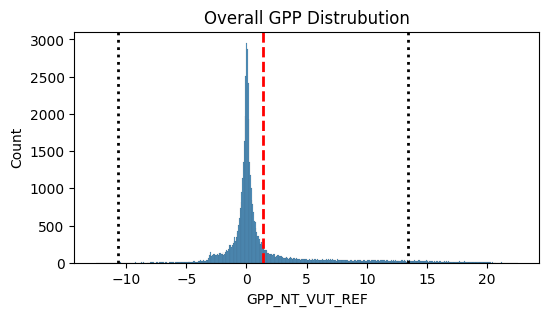

In [5]:
# Get GPP metrics for site metadata
arr = site_df['GPP_NT_VUT_REF']
gpp_mean = np.mean(arr)
gpp_std = np.std(arr)

# Plot hist, add vertical lines for the mean and +/- 3 standard deviations
plt.figure(figsize=(6, 3))
sns.histplot(arr)
plt.axvline(gpp_mean, color='red', linestyle='dashed', linewidth=2)
plt.axvline(gpp_mean + 3 * gpp_std, color='black', linestyle='dotted', linewidth=2)
plt.axvline(gpp_mean - 3 * gpp_std, color='black', linestyle='dotted', linewidth=2)
plt.title('Overall GPP Distrubution')
plt.show()

#### 1.2 SEASONAL

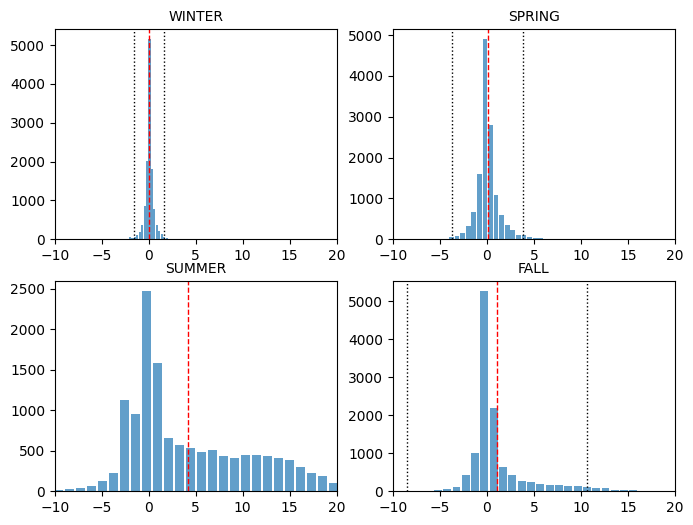

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.ravel()

i = 0 
for szn in ['WINTER', 'SPRING', 'SUMMER', 'FALL']:
    arr = site_df.loc[site_df['SEASON']==szn, 'GPP_NT_VUT_REF']
    mean = np.mean(arr)
    std = np.std(arr)
    axs[i].hist(arr, bins=30, alpha=0.7, rwidth=0.85)
    axs[i].axvline(mean, color='red', linestyle='dashed', linewidth=1)
    axs[i].axvline(mean + 3 * std, color='black', linestyle='dotted', linewidth=1)
    axs[i].axvline(mean - 3 * std, color='black', linestyle='dotted', linewidth=1)
    axs[i].set_title(szn, fontsize=10)
    axs[i].set_xbound(-10, 20)
    i += 1

plt.show()


#### 1.3 MONTHLY

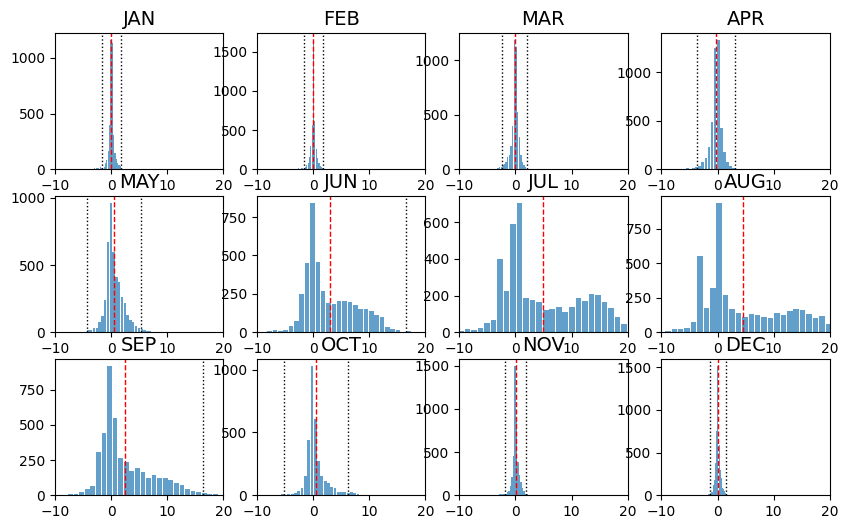

In [7]:
fig, axs = plt.subplots(3, 4, figsize=(10, 6))
axs = axs.ravel()

i = 0 
for month in range(1, 13):
    arr = site_df.loc[site_df['MONTH']==month, 'GPP_NT_VUT_REF']
    mean = np.mean(arr)
    std = np.std(arr)
    axs[i].hist(arr, bins=30, alpha=0.7, rwidth=0.85)
    axs[i].axvline(mean, color='red', linestyle='dashed', linewidth=1)
    axs[i].axvline(mean + 3 * std, color='black', linestyle='dotted', linewidth=1)
    axs[i].axvline(mean - 3 * std, color='black', linestyle='dotted', linewidth=1)
    axs[i].set_title(month_abbreviations[month], fontsize=14)
    axs[i].set_xbound(-10, 20)
    i += 1

plt.show()